## __Predicción de eclipses mediante el uso de Machine Learning__

Durante toda nuestra vida, y desde los inicios mismos de nuestra historia, convivimos con este interesante y notorio fenómeno que, durante mucho tiempo, dio lugar a curiosas e interesantes historias que intentaban explicar su funcionamiento. Hoy, entendemos plenamente su funcionamiento, y, a forma de corolario de la comprensión de la mecánica celeste, somos capaces de predecirlo de forma precisa para nuestro ocio o para usarlo en investigación científica, como se hizo en 1919 para someter a prueba por primera vez la Relatividad General de Einstein.

A pesar de la fuerte comprensión teórica que se tiene actualmente sobre ese y otros fenómenos de la mecánica celeste, resulta difícil a nivel de cálculos y poder de cómputo, desarrollar algoritmos eficientes basados en nuestras teorías que sean capaces de, al mismo tiempo, obtener predicciones precisas y obtener resultados en tiempos de cómputo racionales. Por otro lado, con el actual desarrollo en el campo de la computación y el Aprendizaje Automático (Inteligencia Artificial), se ha notado que, bajo este paradigma, es posible entrenar modelos de aprendizaje que replican de forma correcta, y en tiempos de cálculo mucho más razonables, teorías y leyes físicas de nuestro universo, resultando en modelos de gran interés cuando se quiere replicar la realidad física de forma rápida (como se requiere por ejemplo en el campo de gráficos por computadora). 

Es así, como M. Sferdian, M. Frincu (2021) (https://irep.ntu.ac.uk/id/eprint/44130/), muestran la mejora computacional obtenida entre el métodos clásico implementado en un algoritmo de fuerza bruta, y el entrenamiento de un modelo de Machine Learning para la predicción de eclipses. En el trabajo actual, se replica el trabajo hecho en el artículo para entrenar el modelo de aprendizaje automático.

En el trabajo desarollado por nosotros, implementaremos solo los métodos basados en Machine Learning descritos en el artículo original, a ser, K-Nearest Neighbors, Logistic Regression para clasificación, y Random Forest, además un modelo basado en Redes Neuronales para comparar los resultados. De lo anterior, se obtuvo el mejor resultado para el modelo -simple- basado en redes neuronales, y para este modelo se realizó predicciones de eclipses dada una fecha de entrada como cadena de caracteres siguiendo el formato ```YYYY-MM-DD```.

El método descrito en el artículo para la identificación de eclipses (pag. 8, M. Sferdian, M. Frincy (2021)), se basa en los métodos VSOP87 y ELP-2000/82 para la determinación de coordenadas solares y lunares en el cielo. A partir de ellas, se determina, para cada día en el conjunto de datos original, y para distintas locaciones en la esfera terrrestre cada día, la separación mínima entre los dos cuerpos celestes, conociendo sus radios y teniendo en cuenta las condiciones de un eclipse solar y uno lunar (mes sideral y mes dracónico). Este cálculo representa el parámetro de identificación de eclipses basado en machine learning.

### __Implementación de modelos__

Primero haremos la lectura de datos y la definición de los conjuntos de entrenamiento y de prueba. El conjunto de datos original contiene información desde el año 1999 a.C, hasta el año 2100 d.C, estos datos son obtenidos de bases de datos de la NASA (https://eclipse.gsfc.nasa.gov/), que comprenden un de eclipses solares y lunares desde el año 1999 a.C hasta el año 3000 d.C. 
Para el entrenamiento de nuestros modelos, usaremos un subconjunto del conjunto de datos descargado, que es, a su vez, un subconjunto del los datos originales de la NASA; estos conjuntos de datos se dividen como se describe a continuación.

##### __Conjunto de entrenamiento__
Consiste en datos de eclipses solares desde el primero de enero de 1950 (```1950-01-01```), hasta datos del treinta y uno de diciembre de 2019 (```2019-12-31```). En estos datos se puede corroborar la congruencia con los datos observacionales, como el pasado eclipse del 14 de octubre del 2023.

#### __Conjunto de prueba__
El conjunto de prueba consiste el resto de datos de eclipses solares, desde el primero de enero del 2020 hasta el 31 de diciembre del 2100. Aquí, igualmente, se puede corroborar la congruencia de los datos al comparar con, por ejemplo, los futuros eclipses para el 8 de abril de 2024 y el 29 de marzo de 2025.

Con estos conjuntos de prueba, implementaremos los distintos modelos de Machine Learning utilizando las implementaciones en la librería ```scikit-learn```. Los resultados obtenidos se discuten luego de las implementaciones realizadas.

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from include.Calculations.aux_funcs import get_minimum_separation, get_minimum_separation_lunar
from include.ML.confusion_matrix_helper import make_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Data retrieval, check that the data is already installed in local directory (execute include/get_data.py and check that all the files in data 
# were correctly installed)
df = pd.read_csv('data/solar-eclipses-classif.csv')
df['Is Eclipse'] = df['Is Eclipse'].replace({True: 1, False: 0}) # labels are treated as type int64
# check = df[df['Date'] == '2023-10-14'] # %Y-%M-%D date formatting
# print(check)

bias_pos = df[df['Date'] == '2019-12-31'].index.item() + 1 # sets the position of the given Date as bias for the training set
train, test = df[:bias_pos], df[bias_pos:]
train_labels, test_labels = np.array(train.pop('Is Eclipse')), np.array(test.pop('Is Eclipse'))
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
train, test = train.select_dtypes('number'), test.select_dtypes('number')
# test

In [8]:
# aux function to plot confusion matrix. This function uses the implementation made by the originals authors to plot de confusion matrix but it
# has slight changes made by us
def plot_cf_matrix(test_labels, predictions, accuracy, f1, label = ''):
    cf_matrix = confusion_matrix(test_labels, predictions)
    labels = ['True Negatives','False Positives','False Negatives','True Positives']
    categories = ['No eclipse', 'Elipse']
    make_confusion_matrix(cf_matrix,
                        accuracy = accuracy,
                        f1 = f1,
                        group_names = labels,
                        categories = categories,
                        cbar = False,
                        title = 'Confusion Matrix (' + label + ')',
                        cmap = 'Reds')

### __K-Nearest Neighbors__
El agoritmo K-NN es un algoritmo no supervisado de agrupación de datos, y será la primera implementación que haremos. Los parámetros establecidos antes del entrenamiento del modelo, son resultado de prueba y error hasta obtener una buena precisión. Algunos datos son dejados como el valor por defecto implementado en la librería.

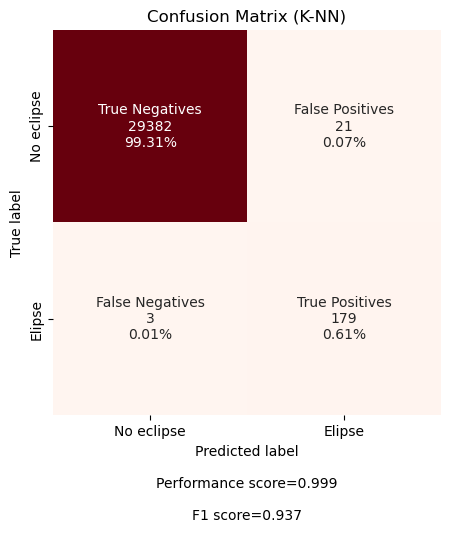

In [3]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(algorithm = 'auto',
    leaf_size = 30,
    metric = 'minkowski',
    n_neighbors = 7,
    p = 2,
    weights = 'uniform'
)
knn_model.fit(train, train_labels)

# metrics
# print(f'Model Accuracy: {knn_model.score(train, train_labels)}')
predictions = knn_model.predict(test)
accuracy = knn_model.score(test, test_labels)
# print(f'Model Accuracy: {accuracy}')
# print(f'Model Score: {knn_model.score(test, test_labels)}')
# print(f'Precision: {precision_score(test_labels, predictions)}')
# print(f'Recall: {recall_score(test_labels, predictions)}')
f1 = f1_score(test_labels, predictions)
# print(f'F1 Score: {f1}')
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'K-NN')

### __Logistic Regression__
La regresión logística resulta ser, en este caso, una aproximación más natural al problema, dado el sistema de clasificación binaria al que apuntamos. En esta implementación todos los parámetros se dejaron iguales a los parámetros por defecto en la librería.

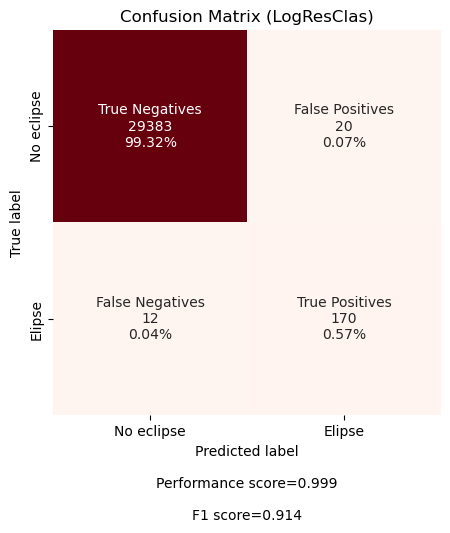

In [15]:
from sklearn.linear_model import LogisticRegression
logclas_model = LogisticRegression()
logclas_model.fit(train, train_labels)

# metrics
# print(f'Model Accuracy: {logreg_model.score(train, train_labels)}')
predictions = logclas_model.predict(test)
# print(f'Model Accuracy: {logreg_model.score(train, train_labels)}')
accuracy = logclas_model.score(test, test_labels)
# print(f'Model Accuracy: {accuracy}')
# print(f'Precision: {precision_score(test_labels, predictions)}')
# print(f'Recall: {recall_score(test_labels, predictions)}')
f1 = f1_score(test_labels, predictions)
# print(f'F1 Score: {f1}')
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'LogResClas')

### __Random Forest Classifier__
De la misma forma que para la clasificación logística, el algoritmo de bosques aleatorios resulta una aproximación más antural al problema, así como a su vez, una mejora en el algortimo de regresión logística, dados los criterios de comparación empleados. En este caso, parámetros como el número de estimadores, no mostraron mayor relevancia a la hora de ejecutar la clasificación.

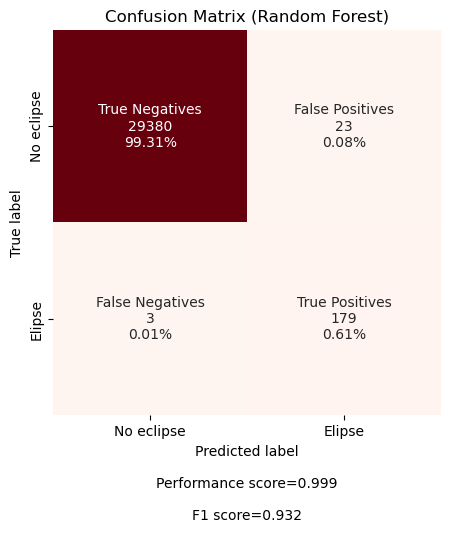

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=50, 
    criterion='gini', 
    max_depth=2, # no overfitting
    min_samples_split=30, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)
rf_model.fit(train, train_labels)
# print(f'Model Accuracy: {rf_model.score(test, test_labels)}')
predictions = rf_model.predict(test)
# print(f'Model Accuracy: {rf_model.score(train, train_labels)}')
accuracy = rf_model.score(test, test_labels)
# print(f'Model Accuracy: {accuracy}')
# print(f'Precision: {precision_score(test_labels, predictions)}')
# print(f'Recall: {recall_score(test_labels, predictions)}')
f1 = f1_score(test_labels, predictions)
# print(f'F1 Score: {f1}')
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'Random Forest')

### __Multi-layer Perceptron Classifier__
Finalmente, hacemos uso de un algoritmo de clasificación basado en redes neuronales con 5 capas ocultas de 5, 8 y 8 neuronas respectivamente, haciendo uso de la función de activación ```relu``` y el algoritmo de optimización ```adam```. Este número de capas y de neuronas son escogidas a través de prueba y error que ofrece un modelo eficiente. Dada la naturaleza de los algoritmos basados en redes neuronal, podemos esperar que esta optimización sea buena, pero no podemos, apriori, estimar qué tanto respecto a los otros métodos.

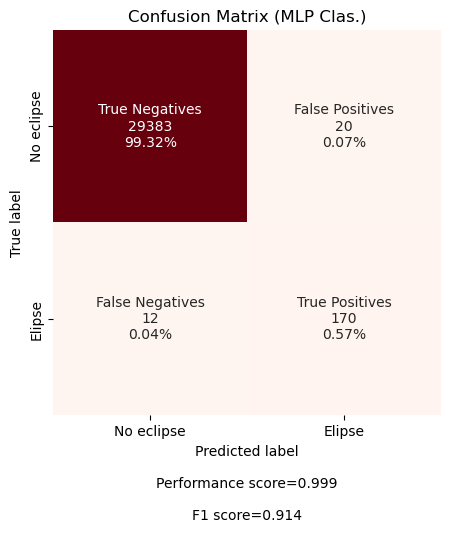

In [6]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(5,8,8), 
    activation='relu', 
    solver='adam', 
    max_iter=500)
mlp_model.fit(train,train_labels)
# print(f'Model Accuracy: {mlp_model.score(test, test_labels)}')
predictions = mlp_model.predict(test)
# print(f'Model Accuracy: {rf_model.score(train, train_labels)}')
accuracy = mlp_model.score(test, test_labels)
# print(f'Model Accuracy: {accuracy}')
# print(f'Precision: {precision_score(test_labels, predictions)}')
# print(f'Recall: {recall_score(test_labels, predictions)}')
f1 = f1_score(test_labels, predictions)
# print(f'F1 Score: {f1}')
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'MLP Clas.')

### __Resultados__
De todos los métodos implementados, el método basado en redes neuronales predijo correctamente un total (TP + TN) de 29553 datos de eclipses, que corresponden a aproximadamente el $99.89\%$ del total de datos. Además de esto, se obtuvo el mejor rendimiento, en términos de eficiencia en tiempos de cálculo, para el algoritmo de clasificación logística, lo cual es esperable si consideramos la naturaleza binaria del problema de clasificación en el que nos encontramos; de la misma forma, y como era de esperarse, el modelo basado en bosques aleatorios, representa un algoritmo con un rendimiento inferior la regresión logística, pero con una mejor precisión, prediciendo correctamente el $99.92\%$ de los datos (TP + TN = 29559), respecto al $99.89\%$ (TP + TN = 29553). El modelo basado en K-NN resultó tener la precisión y rendimientos más bajos, probablemente debido a que el problema no está íntimamente relacionado a su campo de aplicación, a pesar de esto, este algoritmo resulta tener menos equivocaciones al momento de identificar falsos positivos y falsos negativos, obteniendo, en cada caso FP = 21, FN = 3.

El problema con los falsos negativos y falsos positivos puede deberse a la forma en la que se determina si hay un eclipse solar o no. Podemos notar que la mayoría de errores de predicción se encuentran a la hora de identificar aproximaciones sol-luna que no resultan ser eclipses. Es importante ver también que el mejor rendimiento se tiene a la hora de determinar cuándo no hubo un eclipse, y esto presenta un sesgo, dada la cantidad mínima de eclipses respecto al total de días analizados; sin embargo, el porcentaje de identificación de eclipses tampoco está representada notablemente por los porcentajes de errores.

Si tenemos en cuenta este sesgo, y el porcentaje de desaciertos, el mejor resultado se obtiene para el modelo basado en K-NN, y esto se puede deber a que este modelo es capaz de encontrar nuevas características entre los conjuntos de datos que no son contempladas en el modelo original de identificación de eclipses.

### __Predicciones__

Podemos usar la función ```get_separtion()``` para, dada una fecha, predecir si en ese día ocurrirá o no un eclipse. Anque el entrenamiento se hizo para datos de eclipses solares, podemos también probar la precisión de los métodos para identificar eclipses lunares, haciendo uso de la función ```get_separation_lunar()```.

In [16]:
date = '2023-10-14' # solar
print(knn_model.predict([[get_minimum_separation(date)]]))
print(logclas_model.predict([[get_minimum_separation(date)]]))
print(rf_model.predict([[get_minimum_separation(date)]]))
print(mlp_model.predict([[get_minimum_separation(date)]]))

[1]
[1]
[1]
[1]


In [21]:
date = '2024-04-08' # solar
print(mlp_model.predict([[get_minimum_separation(date)]]))

[1]


In [19]:
date = '2025-03-29' #solar
print(mlp_model.predict([[get_minimum_separation(date)]]))

[1]


In [25]:
date = '2023-10-28' # lunar
print(knn_model.predict([[get_minimum_separation_lunar(date)]]))
print(logclas_model.predict([[get_minimum_separation_lunar(date)]]))
print(rf_model.predict([[get_minimum_separation_lunar(date)]]))
print(mlp_model.predict([[get_minimum_separation_lunar(date)]]))

[1]
[1]
[1]
[1]


In [23]:
date = '2023-05-05' # lunar
print(knn_model.predict([[get_minimum_separation_lunar(date)]]))

[1]


Como se puede apreciar, los algoritmos parecen tener la capacidad de predecir eclipses lunares, esto sucede porque los modelos aprenden a identificar eclipses dada una separación adecuada, y dado que el algoritmo original para la obtención de separación, describe simplmente separaciones pequeñas en la bóveda celeste, el algoritmo tiene igualmente una buena precisión a la hora de predecir eclipses lunares. Esto se puede apreciar a pasar los datos de eclipses lunares a un modelo entrenado para identificación de eclipses solares.

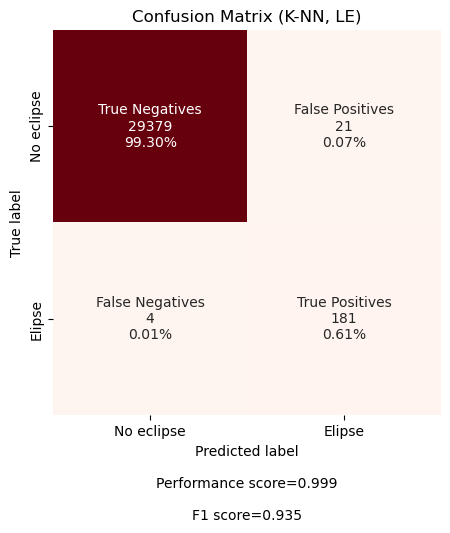

In [33]:
df = pd.read_csv('data/lunar-eclipses-classif.csv')
df['Is Eclipse'] = df['Is Eclipse'].replace({True: 1, False: 0}) # labels are treated as type int64
# check = df[df['Date'] == '2023-10-14'] # %Y-%M-%D date formatting
# print(check)

bias_pos = df[df['Date'] == '2019-12-31'].index.item() + 1 # sets the position of the given Date as bias for the training set
train, test = df[:bias_pos], df[bias_pos:]
train_labels, test_labels = np.array(train.pop('Is Eclipse')), np.array(test.pop('Is Eclipse'))
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
train, test = train.select_dtypes('number'), test.select_dtypes('number')

predictions = knn_model.predict(test)
accuracy = knn_model.score(test, test_labels)
f1 = f1_score(test_labels, predictions)
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'K-NN, LE')

<!-- En general, el rendimiento del algoritmo resulta ser mucho mejor que el método de fuerza bruta calculando las separaciones de los cuerpos celestes. La generación de los datos de entrenamiento implementando este algoritmo, toma alrededor de 30 minutos para identificar eclipses solares y lunares en el intervalo de tiempo especificado anteriormente, lo cual resulta considerablemente mayor al tiempo empleado en el entrenamiento y la posterior identificación del conjunto de prueba utilizando las funciones de ```get_separation()``` dadas las fechas. -->